In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [3]:
df = pd.read_csv('/home/suhas/Desktop/office/Data Science/Notes/Data Analysis/Data/spam.csv')

In [4]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.shape

(5572, 2)

In [6]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [7]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [8]:
# 15% spam emails and 85% ham emails. This indicates class in imbalance
747/4825

0.15481865284974095

In [9]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [10]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [11]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [12]:
df_balanced = pd.concat([df_ham_downsampled,df_spam])
df_balanced.shape

(1494, 2)

In [13]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [14]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
1475,ham,"Friendship is not a game to play, It is not a ...",0
4371,spam,Do you want a new Video handset? 750 any time ...,1
1180,ham,To day class is there are no class.,0
3256,ham,HI ITS KATE CAN U GIVE ME A RING ASAP XXX,0
2255,ham,Ok. Me watching tv too.,0


In [15]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(df_balanced['Message'],df_balanced['spam'],stratify=df_balanced['spam'])

In [16]:
X_train.head()

5232    YOU ARE CHOSEN TO RECEIVE A £350 AWARD! Pls ca...
5427    Santa Calling! Would your little ones like a c...
390       Yup having my lunch buffet now.. U eat already?
3141    sexy sexy cum and text me im wet and warm and ...
4893    Miserable. They don't tell u that the side eff...
Name: Message, dtype: object

In [17]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [18]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "get existing offers hurry up",
    "suhas did you check the mail"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.90749544, -0.45150548, -0.78714526, ..., -0.46598715,
        -0.6513388 ,  0.9181748 ],
       [-0.70603603, -0.2055223 ,  0.14809322, ...,  0.41707698,
        -0.4617104 ,  0.8119539 ]], dtype=float32)>

In [19]:
e = get_sentence_embeding([
    'banana',
    'grapes',
    'mango',
    'jeff bezos',
    'elon musk',
    'dog'
])

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[0]],[e[4]])

array([[0.89336306]], dtype=float32)

In [21]:
# Build the model

text_input = tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [22]:
# Neural Network layers
l = tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

In [23]:
#Use inputs and outputs to construct a final model

model = tf.keras.Model(inputs=[text_input],outputs=[l])

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'sequence_output':  109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [25]:
len(X_train)

1120

In [26]:
Metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=Metrics)

In [27]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
35/35 [==============================] - 210s 6s/step - loss: 0.6044 - accuracy: 0.7063 - precision: 0.7081 - recall: 0.7018
Epoch 2/10
35/35 [==============================] - 243s 7s/step - loss: 0.4746 - accuracy: 0.8366 - precision: 0.8313 - recall: 0.8446
Epoch 3/10
35/35 [==============================] - 232s 7s/step - loss: 0.4072 - accuracy: 0.8580 - precision: 0.8381 - recall: 0.8875
Epoch 4/10
35/35 [==============================] - 205s 6s/step - loss: 0.3701 - accuracy: 0.8768 - precision: 0.8676 - recall: 0.8893
Epoch 5/10
35/35 [==============================] - 221s 6s/step - loss: 0.3435 - accuracy: 0.8813 - precision: 0.8637 - recall: 0.9054
Epoch 6/10
35/35 [==============================] - 224s 6s/step - loss: 0.3214 - accuracy: 0.8938 - precision: 0.8835 - recall: 0.9071
Epoch 7/10
35/35 [==============================] - 250s 7s/step - loss: 0.3064 - accuracy: 0.8964 - precision: 0.8828 - recall: 0.9143
Epoch 8/10
35/35 [==============================

In [28]:
model.evaluate(X_test,y_test)

12/12 [==============================] - 94s 8s/step - loss: 0.2376 - accuracy: 0.9251 - precision: 0.9119 - recall: 0.9412


[0.2376125603914261,
 0.9251337051391602,
 0.9119170904159546,
 0.9411764740943909]

In [29]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

In [30]:
import numpy as np

y_pred = np.where(y_pred > 0.5,1,0)
y_pred

array([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,

In [31]:
from sklearn.metrics import confusion_matrix,classification_report

cm = confusion_matrix(y_test,y_pred)
cm

array([[170,  17],
       [ 11, 176]])

Text(33.0, 0.5, 'Truth')

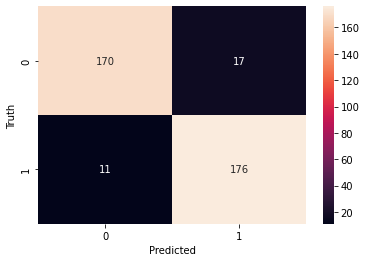

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [33]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       187
           1       0.91      0.94      0.93       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.93       374
weighted avg       0.93      0.93      0.93       374



In [34]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.7262063 ],
       [0.81691587],
       [0.7681358 ],
       [0.2298156 ],
       [0.11082906]], dtype=float32)

In [35]:
predictions = model.predict(reviews).flatten()

In [39]:
binary_predictions = np.where(predictions > 0.5, 1.0, 0.0)

# Fix the loop to correctly zip the values
for review, pred, binary in zip(reviews, predictions, binary_predictions):
    label = "Spam" if binary == 1 else "Not Spam"
    print(f"Review: {review}\n Predictions: {pred:.2f} --> {label}\n")

Review: Enter a chance to win $5000, hurry up, offer valid until march 31, 2021
 Predictions: 0.73 --> Spam

Review: You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99
 Predictions: 0.82 --> Spam

Review: it to 80488. Your 500 free text messages are valid until 31 December 2005.
 Predictions: 0.77 --> Spam

Review: Hey Sam, Are you coming for a cricket game tomorrow
 Predictions: 0.23 --> Not Spam

Review: Why don't you wait 'til at least wednesday to see if you get your .
 Predictions: 0.11 --> Not Spam

